### Step by step design
1. Simulate Rankings of Relevance E and P
2. Calculate delta ERR
3. Implement Team-Draft (5pts) and Probabilistic Interleaving (35pts)
4. Simulate User Clicks (40pts)
5. Simulate Interleaving Experiment
6. Compute Sample Size
7. Analysis (20pts)

Homework description: https://docs.google.com/document/d/1sNat5t1asD6Jj7eCSWo_9esHoFYWrw9wjwE3kMdgMxc/edit#



In [2]:
import numpy as np
import itertools
import random as rnd

import matplotlib.pyplot as plt
import seaborn as sns

ModuleNotFoundError: No module named 'seaborn'

In [3]:
CUT_OFF_RANK = 3
ranking_scale = range(2)

In [4]:
# simulate all pairs of E and P
ranking_results = list(itertools.product(ranking_scale, repeat=CUT_OFF_RANK))
print(ranking_results)
all_pairs = list(itertools.product(ranking_results, repeat=2))
#print(all_pairs)
print(len(all_pairs))

[(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]
64


1

In [5]:
def rel_grade_to_prob(grade):
    #map relevance grade to probability
    R_i = (2**grade)-1 / 2**(np.amax(ranking_scale))
    return R_i


def compute_err(ranked_results):
    #According to Algorithm 2 in ERR-paper
    err = 0    
    for r in range(1,CUT_OFF_RANK+1):        
        R_r = rel_grade_to_prob(ranked_results[r-1])
        for i in range(1,r):
            R_i = rel_grade_to_prob(ranked_results[i-1])
            R_r = R_r * (1-R_i)        
        err += R_r / r
        
    return err

In [6]:
#create lookup table for ranked_results - ERR
dict_results_err = {}
for ranked_list in ranking_results:
    dict_results_err[ranked_list] = compute_err(ranked_list)
    
print(list(dict_results_err.items()))

[((0, 0, 0), 0.66666666666666663), ((0, 0, 1), 0.75), ((0, 1, 0), 0.83333333333333337), ((0, 1, 1), 0.75), ((1, 0, 0), 1.3333333333333333), ((1, 0, 1), 1.25), ((1, 1, 0), 1.1666666666666667), ((1, 1, 1), 1.25)]


In [7]:
[(0.05,0.1),(0.1,0.2),(0.2,0.3),(0.3,0.4),(0.4,0.5)]

[(0.05, 0.1), (0.1, 0.2), (0.2, 0.3), (0.3, 0.4), (0.4, 0.5)]

In [8]:
lower_bonds = np.round(np.linspace(0,1,num=10, endpoint=False), decimals=2)
lower_bonds[0] = 0.05
upper_bonds = np.round(np.linspace(0.1,1,num=10), decimals=2)
upper_bonds[-1] = 0.95
bins = list(zip(lower_bonds, upper_bonds))
print(bins)

[(0.050000000000000003, 0.10000000000000001), (0.10000000000000001, 0.20000000000000001), (0.20000000000000001, 0.29999999999999999), (0.29999999999999999, 0.40000000000000002), (0.40000000000000002, 0.5), (0.5, 0.59999999999999998), (0.59999999999999998, 0.69999999999999996), (0.69999999999999996, 0.80000000000000004), (0.80000000000000004, 0.90000000000000002), (0.90000000000000002, 0.94999999999999996)]


0.6666666666666666

In [9]:
#Compute delta ERR
dict_rel_pairs = {}
for upper in upper_bonds:
    dict_rel_pairs[upper] = []
all_delta_err = []
rel_delta_err = []

for pair in all_pairs:    
    #compute delta ERR   
    delta_err = dict_results_err[pair[0]] - dict_results_err[pair[1]]    
    #add pair to corresponding group if E outperforms P
    if delta_err > lower_bonds[0]:        
        for bond in upper_bonds:            
            if delta_err < bond:                
                dict_rel_pairs[bond].append(pair)                
                rel_delta_err.append(delta_err)                
                break

In [120]:
#plt.hist(all_delta_err, bins=10)

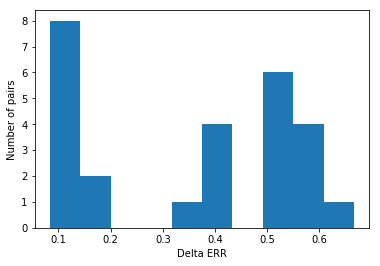

In [10]:
plt.hist(rel_delta_err, bins=10)
plt.ylabel("Number of pairs")
plt.xlabel("Delta ERR")

<b>Comment:</b> 
In interleaving: should we use document id's in order to prevent selecting the same document twice? 

Teacher said on (https://piazza.com/class/jp4hjyhusbk5i3?cid=41) that we should assume all cases (e.g. duplicate, replacement, ...). For me that means that we should implement something like document id's (at least in one instance) [HB]

In [11]:
# add document numbers which allow that the documents returned can be distict but also can overlap
# we considered there are 30 distinct documents in the collection D
# we need these numbers for correctly computing Team-Draft/Probabilistic Interleaving
def assign_doc_labels(pair):
    labeled_pair = []
    for ranked_list in pair:
        doc_labels = []
        docs_l = rnd.sample(range(1, 30), 3)        
        for i in docs_l:
            #generate doc labels
            doc_labels.append("d{0}".format(i))
            
        labeled_pair.append(list(zip(doc_labels,ranked_list)))
    return labeled_pair

In [12]:
# TEAM-DRAFT INTERLEAVING

# function which deletes a document from a list of documents
def remove_document_from_list(d, d_list):    
    for doc in d_list:        
        if d[0] == doc[0]:
            d_list.remove(doc)
            break


def team_draft_interleaving(pair, max_length=3):
    '''
    Input: pair of labelled search results from E and P
    Output: Interleaved list that mixes the documents
    
    team-draft: select one of two lists with p=0.5 and aggregate top result to interleaved list
    
    Optional: team-id, document-id, max_length, 
    '''
    labeled_pair = assign_doc_labels(pair) # list(doc_id , relevance_grade)
    teams = {"E": list(labeled_pair[0]), "P": list(labeled_pair[1])}
    interleaved_list = []
    team_E = 0
    team_P = 0   
    
    while(len(interleaved_list) < max_length):        
        if team_E < team_P:
            chosen_team = 'E'                  
            chosen_doc = teams['E'].pop(0)
            team_E += 1
            remove_document_from_list(chosen_doc,teams['P'])
        elif team_E > team_P:
            chosen_team = 'P'                    
            chosen_doc = teams['P'].pop(0)
            team_P += 1
            remove_document_from_list(chosen_doc,teams['E'])
        elif team_E == team_P:
            chosen_team = rnd.choice(list(teams.keys()))        
            chosen_doc = teams[chosen_team].pop(0)
            if chosen_team == 'E':               
                team_E += 1
                remove_document_from_list(chosen_doc,teams['P'])
            else:             
                team_P += 1
                remove_document_from_list(chosen_doc,teams['E'])                
                
        interleaved_list.append((chosen_team,chosen_doc[1]))        

    return interleaved_list

In [13]:
test_pairs = dict_rel_pairs[0.1][:4]

In [14]:
for pair in test_pairs:
    print(assign_doc_labels(pair))

[[('d21', 0), ('d16', 0), ('d14', 1)], [('d22', 0), ('d15', 0), ('d9', 0)]]
[[('d13', 0), ('d24', 1), ('d22', 0)], [('d1', 0), ('d16', 0), ('d28', 1)]]
[[('d6', 0), ('d9', 1), ('d17', 0)], [('d21', 0), ('d16', 1), ('d23', 1)]]
[[('d26', 0), ('d7', 1), ('d21', 1)], [('d19', 0), ('d8', 0), ('d7', 0)]]


In [15]:
for pair in test_pairs:
    print(pair)
    print(team_draft_interleaving(pair))
    #print(pair)
    print("----")

((0, 0, 1), (0, 0, 0))
[('E', 0), ('P', 0), ('P', 0)]
----
((0, 1, 0), (0, 0, 1))
[('E', 0), ('P', 0), ('E', 1)]
----
((0, 1, 0), (0, 1, 1))
[('P', 0), ('E', 0), ('E', 1)]
----
((0, 1, 1), (0, 0, 0))
[('P', 0), ('E', 0), ('E', 1)]
----


In [16]:
def inverse_power(x, power):
    return 1/(x**power)

def softmax_probabilities(num_ranks, tau=3):
    #Following formula (1) from Probabilistic Interleaving paper
    softmax_probs = []
    ranks = range(1, num_ranks+1)
    denominator = sum(list(inverse_power(r,tau) for r in ranks))
    #print(denominator)
    for rank in ranks:
        softmax_probs.append(inverse_power(rank,tau)/denominator)
    
    return softmax_probs

def probabilistic_interleaving(pair, max_length=3):
    interleaved_list = []
    labeled_pair = assign_doc_labels(pair) # list(doc_id , relevance_grade)
    teams = {"E": list(labeled_pair[0]), "P": list(labeled_pair[1])}
    
    while(len(interleaved_list) < max_length):
        chosen_team = rnd.choice(list(teams.keys()))
        if chosen_team == 'E':
            other_team = 'P'
        else:
            other_team = 'E'            
        chosen_list = teams[chosen_team]        
        
        softmax_samples = softmax_probabilities(len(chosen_list))
        uni_sample = np.random.uniform(low=0.0, high=1.0)
        threshold = 0
        #select doc from list with respect to probabilities
        for prob in softmax_samples:
            threshold += prob            
            if uni_sample < threshold:                
                chosen_doc = chosen_list.pop(softmax_samples.index(prob))
                remove_document_from_list(chosen_doc,teams[other_team])            
                interleaved_list.append((chosen_team,chosen_doc[1]))                  
                break               
    
    return interleaved_list

In [19]:
for pair in test_pairs:
    print(pair)
    print(probabilistic_interleaving(pair))
    #print(pair)
    print("----")

((0, 0, 1), (0, 0, 0))
[('P', 0), ('P', 0), ('E', 0)]
----
((0, 1, 0), (0, 0, 1))
[('P', 0), ('P', 0), ('P', 1)]
----
((0, 1, 0), (0, 1, 1))
[('P', 0), ('E', 0), ('P', 1)]
----
((0, 1, 1), (0, 0, 0))
[('E', 0), ('P', 0), ('E', 1)]
----


In [183]:
softmax_probabilities(3)

[0.8605577689243028, 0.10756972111553785, 0.03187250996015936]